In [140]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import data

from batchgenerators.dataloading.data_loader import DataLoaderBase
from data_augmenter import get_training_transforms
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Let's create a DataLoader that gives us some image. Your implementation will vary depending on your dataset. Here we just output the same image all the time.

In [141]:
import os
import numpy as np
from skimage.io import imread
import torch
import matplotlib.pyplot as plt
from batchgenerators.dataloading.data_loader import SlimDataLoaderBase
from batchgenerators.transforms.color_transforms import ContrastAugmentationTransform
from batchgenerators.transforms.spatial_transforms import MirrorTransform
from batchgenerators.transforms.abstract_transforms import Compose
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter
from multithreaded_dataloading import ImageDataset

# Function to load images from a folder
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = imread(os.path.join(folder_path, filename))
        if img is not None:
            images.append(img)
    return images


## Now we can get some batches:

In [142]:
# Load images from the specified folder
folder_path = '../../../../AI4MI/data/SEGTHOR_MANUAL_SPLIT/train/img'
train_data = load_images_from_folder(folder_path)

# Create dataset and CustomDataLoader with batch size of 4
batch_size = 4


In [147]:
type(train_data[0][0][0])

numpy.uint8

In [ ]:
batchgen = ImageDataset(train_data, batch_size=batch_size)

# Plotting function for batches
def plot_batch(batch):
    batch_size = batch['data'].shape[0]
    plt.figure(figsize=(16, 10))
    for i in range(batch_size):
        plt.subplot(1, batch_size, i+1)
        plt.imshow(batch['data'][i, 0], cmap="gray")  # Only grayscale image here (1, H, W)
        plt.axis('off')
    plt.show()

batch = next(batchgen)
plot_batch(batch)

## It's time for some transformations! 
We are not going to waste any time and do it multithreaded

In [4]:
from batchgenerators.transforms.color_transforms import ContrastAugmentationTransform
from batchgenerators.transforms.spatial_transforms import MirrorTransform
from batchgenerators.transforms.abstract_transforms import Compose
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter

my_transforms = []
brightness_transform = ContrastAugmentationTransform((0.3, 3.), preserve_range=True)
my_transforms.append(brightness_transform)
mirror_transform = MirrorTransform(axes=(0, 1))
my_transforms.append(mirror_transform)

all_transforms = Compose(my_transforms)
multithreaded_generator = MultiThreadedAugmenter(batchgen, all_transforms, 4, 2, seeds=None)

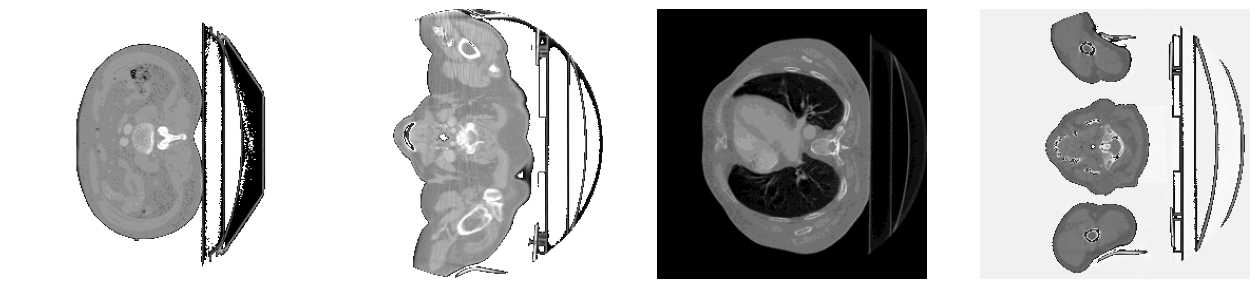

In [5]:
# you can run this line several times to see different outputs
plot_batch(multithreaded_generator.next())

In [6]:
multithreaded_generator._finish() # kill the workers

## Lets add some deformations, scaling and rotations. 
We use very aggressive parameters here to visualize the effects. In your experiment you should choose parameters that make sense in the context of your data.
Not how we are using angle_z here. We are rotating around the (nonexistent) z axis. Always double check whether the rotations are around the correct axis.

In [7]:
from batchgenerators.transforms.spatial_transforms import SpatialTransform

# Create a custom data loader with batchgenerators

spatial_transform = SpatialTransform(train_data[0].shape, np.array(train_data[0].shape) // 2, 
                 do_elastic_deform=True, alpha=(0., 1500.), sigma=(30., 50.),
                 do_rotation=True, angle_z=(0, 2 * np.pi),
                 do_scale=True, scale=(0.3, 3.), 
                 border_mode_data='constant', border_cval_data=0, order_data=1,
                 random_crop=False)

my_transforms.append(spatial_transform)
all_transforms = Compose(my_transforms)
multithreaded_generator = MultiThreadedAugmenter(batchgen, all_transforms, 4, 2, seeds=None)

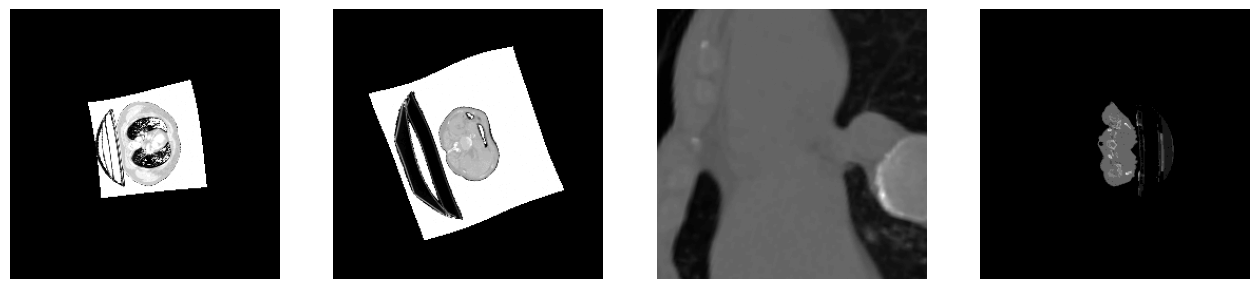

In [8]:
# you can run this line several times to see different outputs. Note how the computation takes long for the 
# first run, but then the batches are returnes very quickly!
plot_batch(next(multithreaded_generator))

## Some timings

In [9]:
# let's do some timing
from time import time

batch_times = []
multithreaded_generator = MultiThreadedAugmenter(batchgen, all_transforms, 4, 2, seeds=None)
for _ in range(20):
    start = time()
    _ = next(multithreaded_generator)
    batch_times.append(time() - start)
    print("This batch took %02.3f s" % batch_times[-1])

avg_batch_time_mt = np.mean(batch_times)
print("Multi threaded batch generation using 4 workers took %02.3f s on average per batch" % avg_batch_time_mt)


batch_times = []
multithreaded_generator = MultiThreadedAugmenter(batchgen, all_transforms, 1, 2, seeds=None)
for _ in range(20):
    start = time()
    _ = next(multithreaded_generator)
    batch_times.append(time() - start)
    print("This batch took %02.3f s" % batch_times[-1])

avg_batch_time_st = np.mean(batch_times)
print("Single threaded batch generation using 4 workers took %02.3f s on average per batch" % avg_batch_time_st)

print("Multi threaded speedup: %02.2f" % (avg_batch_time_st/avg_batch_time_mt))

This batch took 3.581 s
This batch took 0.000 s
This batch took 0.000 s
This batch took 0.283 s
This batch took 0.000 s
This batch took 0.000 s
This batch took 0.000 s
This batch took 0.116 s
This batch took 0.000 s
This batch took 0.000 s
This batch took 0.000 s
This batch took 0.162 s
This batch took 0.000 s
This batch took 0.000 s
This batch took 0.000 s
This batch took 0.090 s
This batch took 0.000 s
This batch took 0.000 s
This batch took 0.000 s
This batch took 0.121 s
Multi threaded batch generation using 4 workers took 0.218 s on average per batch
This batch took 1.162 s
This batch took 0.122 s
This batch took 0.116 s
This batch took 0.120 s
This batch took 0.120 s
This batch took 0.095 s
This batch took 0.150 s
This batch took 0.100 s
This batch took 0.123 s
This batch took 0.100 s
This batch took 0.100 s
This batch took 0.115 s
This batch took 0.095 s
This batch took 0.148 s
This batch took 0.100 s
This batch took 0.099 s
This batch took 0.124 s
This batch took 0.121 s
This b

### Sometimes you don't want to apply a transformation to every batch. We've got you covered:

In [10]:
from batchgenerators.transforms.abstract_transforms import RndTransform

sometimes_spatial_transform = RndTransform(spatial_transform, prob=0.5)
multithreaded_generator = MultiThreadedAugmenter(batchgen, Compose([sometimes_spatial_transform]), 4, 2, seeds=None)

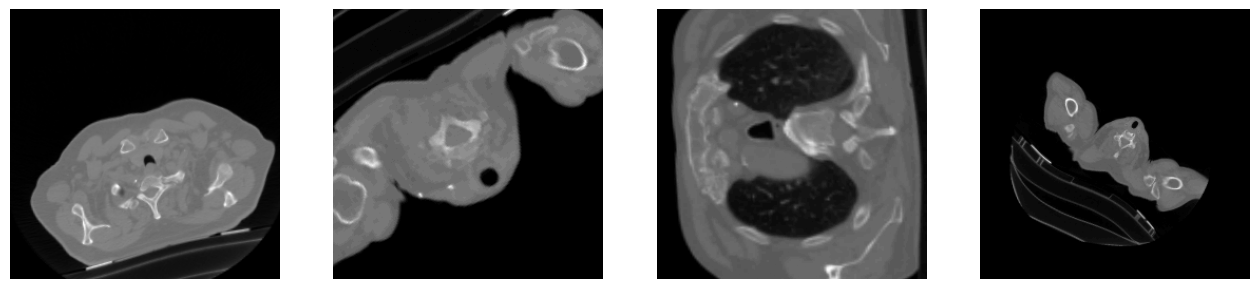

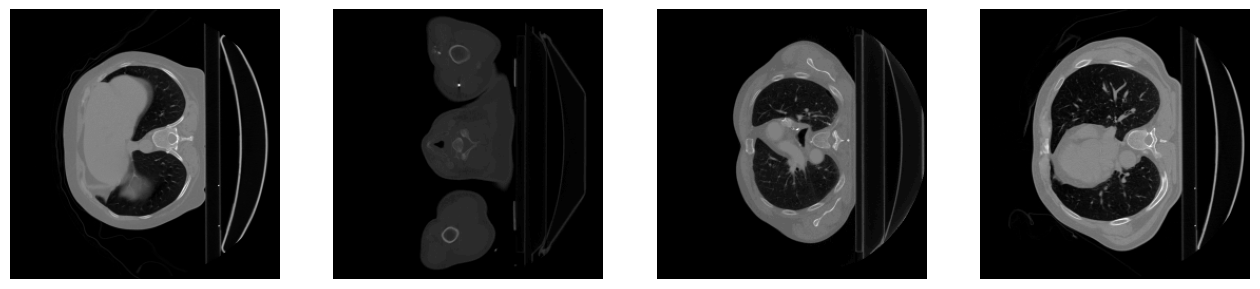

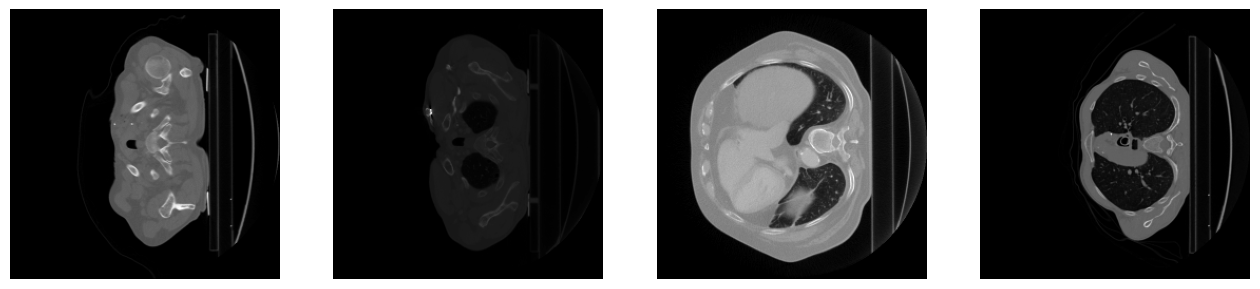

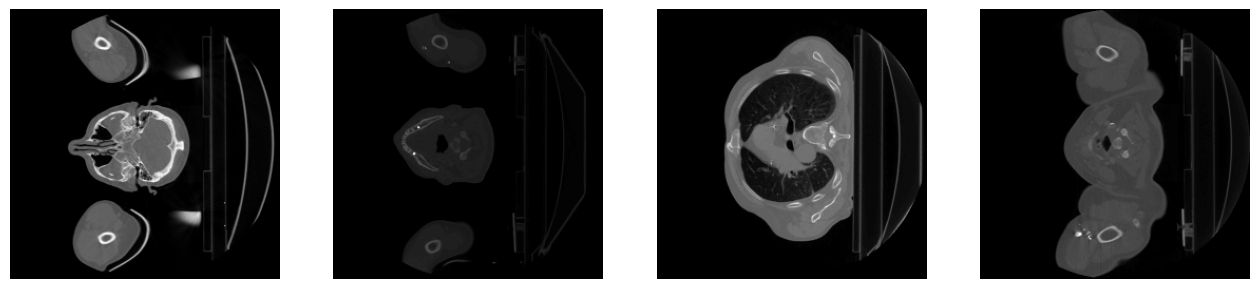

In [11]:
for _ in range(4):
    plot_batch(next(multithreaded_generator))

## Cropping

Usually when you train you need an input patch of a specific size. This is especially true for some segementation problems. If you are NOT using the SpatialTransform then just use the RandomCropTransform or CenterCropTransform. Your DataLoader can in this case return an arbitrarily sized image and you can crontrol the size with those (what is most efficient depends on how your dataset is implemented. I am using numpy memmaps and therefore always return the full size). If you are using SpatialTransform then you can use it to crop your data at the same time they are transformed. “But wait - will transforming a large image not be super slow”? No, because the way SpatialTransform works is that is creates a coordinate grid that is transformed and in the end the data is interpolated along that grid. The computation time therefore depends only on the output patch size. Also, if you have a 128x128 patch that you then transform spatially, you will get border artifacts. If you instead plug the entire image into the SpatialTransform and tell it to extract a 128x128 patch then you can avoid these artifacts!

Crop followed by SpatialTransform (20 batches) took: 4.424 s


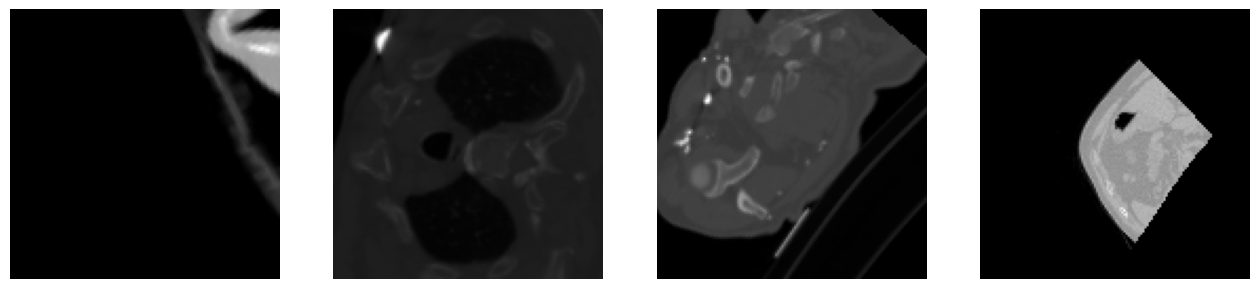




Crop integrated into SpatialTransform (20 batches) took: 4.499 s


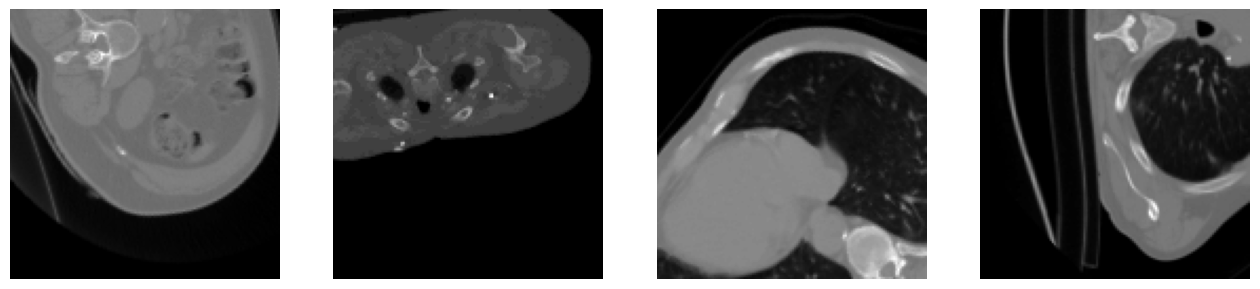

In [12]:
# Spatial augmentation with small patches, crop first then transform (do not do this)
from batchgenerators.transforms.crop_and_pad_transforms import RandomCropTransform
crop_size = (128, 128)

crop = RandomCropTransform(crop_size=crop_size)
spatial_transform = SpatialTransform(crop_size, np.array(crop_size) // 2, 
                 do_elastic_deform=True, alpha=(0., 1500.), sigma=(30., 50.),
                 do_rotation=True, angle_z=(0, 2 * np.pi),
                 do_scale=True, scale=(0.5, 2),
                 border_mode_data='constant', border_cval_data=0, order_data=1,
                 random_crop=False)
multithreaded_generator = MultiThreadedAugmenter(batchgen, Compose([crop, spatial_transform]), 4, 2, seeds=None)

# time it
start = time()
for _ in range(100):
    _ = next(multithreaded_generator)
print("Crop followed by SpatialTransform (20 batches) took: %02.3f s" % (time()-start))

plot_batch(next(multithreaded_generator))

print("\n\n")

# spatial augmentation with snall patches, transform and crop together (do this!)
spatial_transform = SpatialTransform(crop_size, np.array(crop_size) // 2,
                 do_elastic_deform=True, alpha=(0., 1500.), sigma=(30., 50.),
                 do_rotation=True, angle_z=(0, 2 * np.pi),
                 do_scale=True, scale=(0.5, 2),
                 border_mode_data='constant', border_cval_data=0, order_data=1,
                 random_crop=True)
multithreaded_generator = MultiThreadedAugmenter(batchgen, Compose([spatial_transform]), 4, 2, seeds=None)

# time it
start = time()
for _ in range(100):
    _ = next(multithreaded_generator)
print("Crop integrated into SpatialTransform (20 batches) took: %02.3f s" % (time()-start))

plot_batch(next(multithreaded_generator))

As you can see you are much less likely to get border artifacts when using the second option. Output is in each case a batch with size 128x128 pixels and computation time is the same!

## Noise

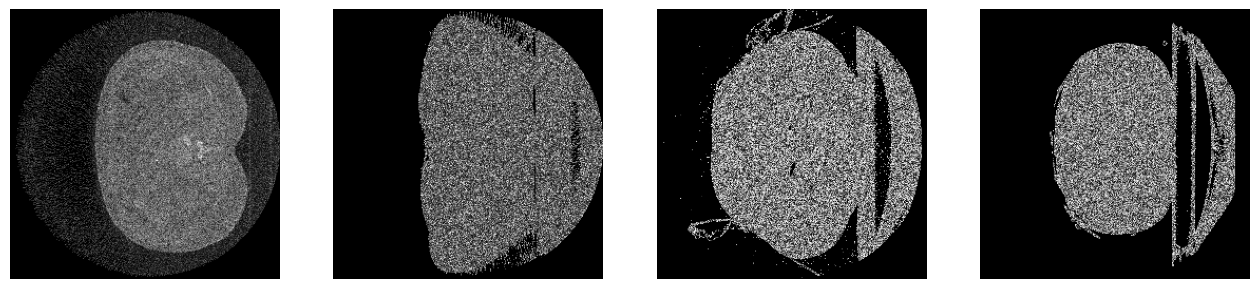

In [13]:
from batchgenerators.transforms.noise_transforms import RicianNoiseTransform
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter

noise_transform = RicianNoiseTransform(noise_variance=(0, 200))
multithreaded_generator = MultiThreadedAugmenter(batchgen, noise_transform, 4, 2, seeds=None)

# you can run this line several times to see different outputs
plot_batch(next(multithreaded_generator))

## Resampling

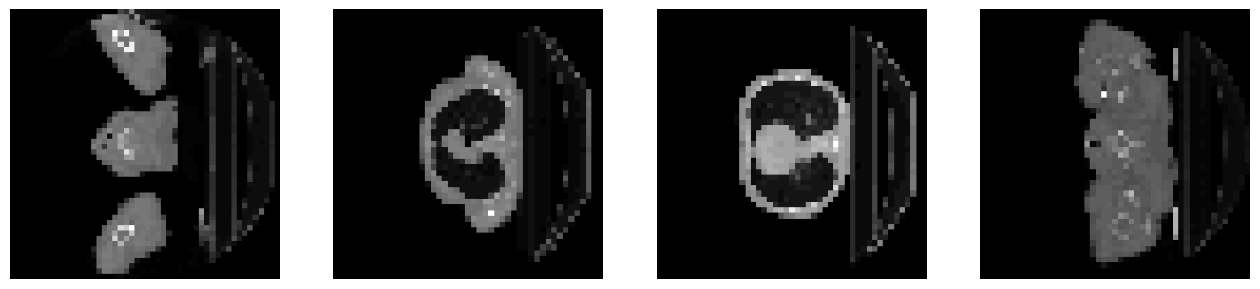

In [14]:
from batchgenerators.transforms.resample_transforms import ResampleTransform
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter

resample_transform = ResampleTransform(zoom_range=(0.05, 0.2))
multithreaded_generator = MultiThreadedAugmenter(batchgen, resample_transform, 1, 2, seeds=None)

# you can run this line several times to see different outputs
plot_batch(next(multithreaded_generator))

### We hope this tutorial helped. For suggestions please contact us ;-)

# Zelf proberen

## Rotation & scaling

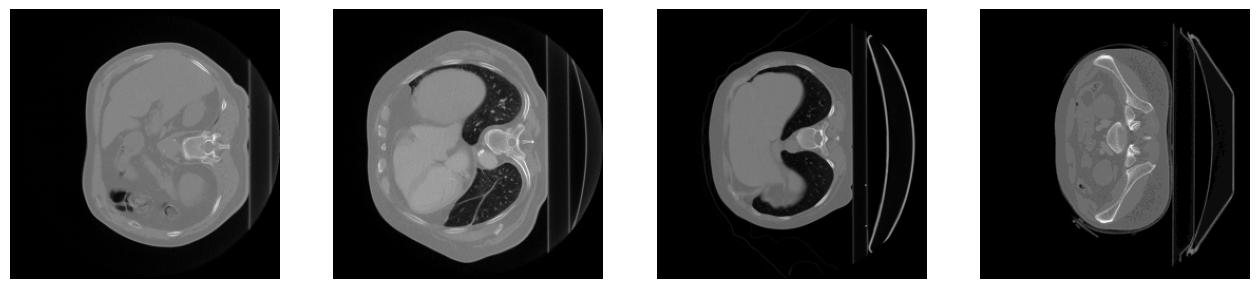

In [105]:

# Define the rotation transform, making sure all other transformations are disabled
target_patch_size = train_data[0].shape  # Example final patch size for training
oversized_patch_size = (int(target_patch_size[0] * 1.2), int(target_patch_size[1] * 1.2))


# Define the rotation-only transform, making sure all other transformations are disabled
rotation_transform = SpatialTransform(
    patch_size=target_patch_size,  # Output image patch size after padding
    patch_center_dist_from_border=np.array(oversized_patch_size) // 2,  # Center the patch

    # Enable rotation
    do_rotation=True,
    angle_x=(-0.174532925, 0.174532925),  # Rotate between -10 to +10 degrees on the z-axis

    # Disable all other transformations
    do_elastic_deform=False,  # Disable elastic deformation
    do_scale=False,  # Disable scaling
    random_crop=False,  # Disable random cropping (center crop is used by default)
    independent_scale_for_each_axis=False,  # Disable independent scaling

    # Border handling (to avoid artifacts when rotating)
    border_mode_data='constant',  # Handle borders by padding with constant values
    border_cval_data=0,  # Pad the image with 0 (black) outside its original boundaries
    order_data=1  # Linear interpolation for smooth rotation
)

# sample how often rotation
rotation_transform = RndTransform(rotation_transform, prob=0.2)

multithreaded_generator = MultiThreadedAugmenter(batchgen, Compose([rotation_transform]), 4, 2, seeds=None)

plot_batch(next(multithreaded_generator))


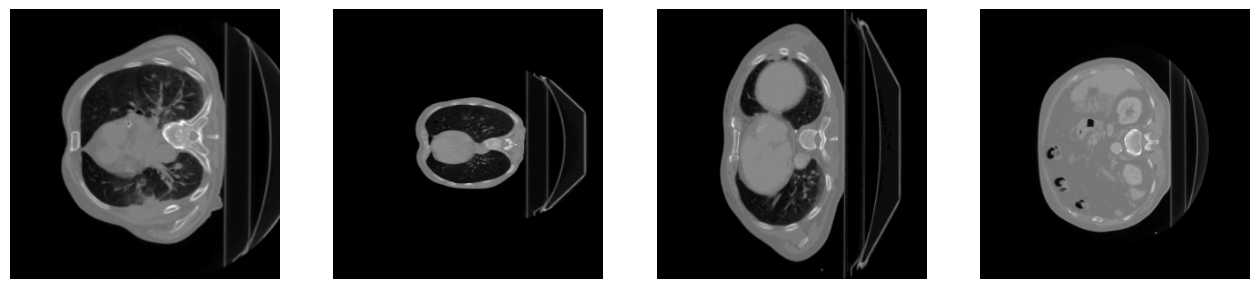

In [114]:
# Define the rotation transform, making sure all other transformations are disabled

# Define the rotation-only transform, making sure all other transformations are disabled
scale_transform = SpatialTransform(
    patch_size=oversized_patch_size,  # Output image patch size after padding
    patch_center_dist_from_border=np.array(oversized_patch_size) // 2,  # Center the patch

    # Enable rotation
    do_rotation=False,
    # Disable all other transformations
    do_elastic_deform=False,  # Disable elastic deformation
    do_scale=True,  # Disable scaling
    scale=(0.7, 1.4),  # Scale between 0.5 and
    random_crop=False,  # Disable random cropping (center crop is used by default)
    independent_scale_for_each_axis=True,  # Disable independent scaling

    # Border handling (to avoid artifacts when rotating)
    border_mode_data='constant',  # Handle borders by padding with constant values
    border_cval_data=0,  # Pad the image with 0 (black) outside its original boundaries
    order_data=1  # Linear interpolation for smooth rotation
)

scale_transform = RndTransform(scale_transform, prob=0.2)

multithreaded_generator = MultiThreadedAugmenter(batchgen, Compose([rotation_transform,scale_transform]), 4, 2, seeds=None)

plot_batch(next(multithreaded_generator))


## Gaussian noise and blur


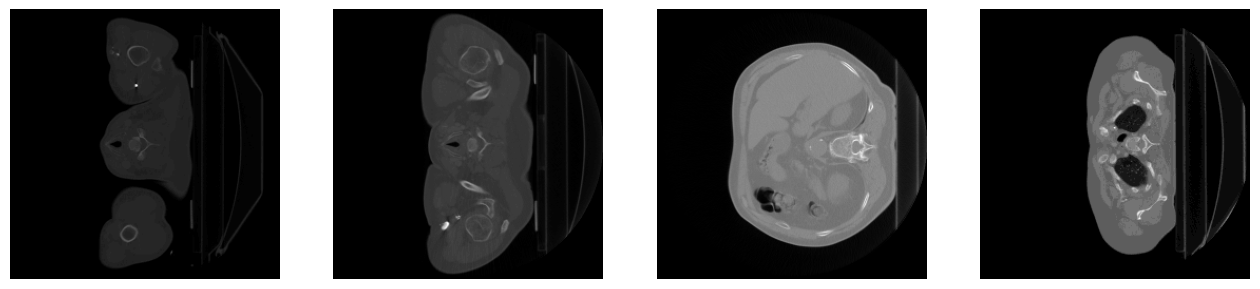

In [89]:
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform
# Define the Gaussian noise transform
noise_transform = GaussianNoiseTransform(
    noise_variance=(0, 0.1),  # Noise variance drawn from U(0, 0.1)
    p_per_sample=0.15  # Probability of applying the noise is 0.15
)

# Initialize the multi-threaded augmenter with noise transformation
multithreaded_generator = MultiThreadedAugmenter(
    batchgen,  # Your batch generator that provides batches of images
    Compose([noise_transform]),  # Apply only the noise transform
    num_processes=4,  # Number of parallel processes
    num_cached_per_queue=2,  # Number of batches to cache in memory
    seeds=None  # Use random seeds for augmentation
)

# Plot the next augmented batch
plot_batch(next(multithreaded_generator))

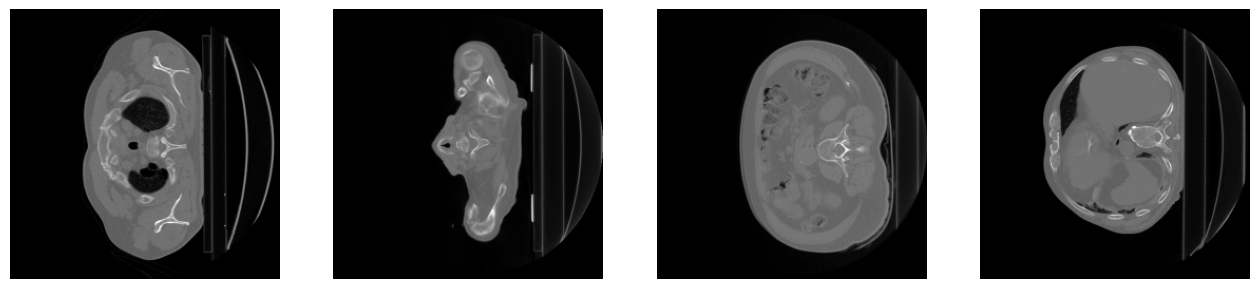

In [90]:
from batchgenerators.transforms.noise_transforms import GaussianBlurTransform

# Define the Gaussian blur transform
blur_transform = GaussianBlurTransform(
    blur_sigma=(0.5, 1.5),  # Gaussian kernel width sampled from U(0.5, 1.5)
    different_sigma_per_channel=True,  # Each modality (channel) gets its own independent sigma
    p_per_sample=0.2,  # Probability of applying blur to the sample is 0.2
    p_per_channel=0.5  # Probability of applying blur to each modality is 0.5
)

# Initialize the multi-threaded augmenter with Gaussian blur transformation
multithreaded_generator = MultiThreadedAugmenter(
    batchgen,  # Your batch generator that provides batches of images
    Compose([blur_transform]),  # Apply the Gaussian blur transform
    num_processes=4,  # Number of parallel processes
    num_cached_per_queue=2,  # Number of batches to cache in memory
    seeds=None  # Use random seeds for augmentation
)

# Plot the next augmented batch
plot_batch(next(multithreaded_generator))

## Brightness and contrast

<class 'multithreaded_dataloading.ImageDataset'>


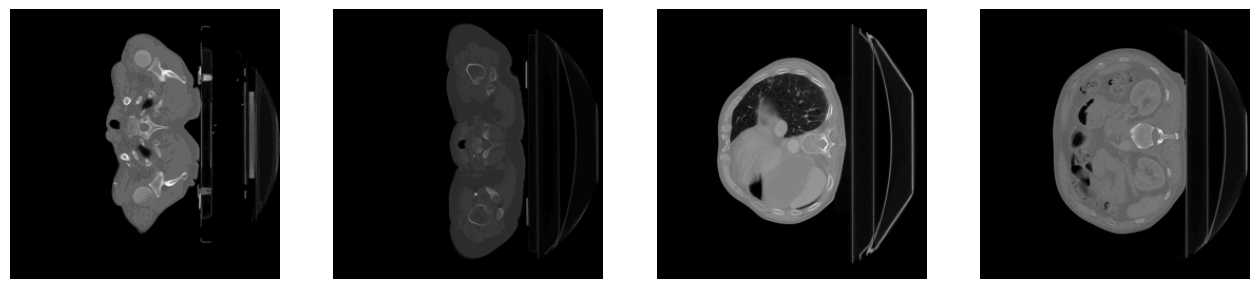

In [91]:
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, ContrastAugmentationTransform
import numpy as np
from batchgenerators.transforms.abstract_transforms import AbstractTransform

print(type(batchgen))
# Define the Contrast Transform
brightness_transform = BrightnessMultiplicativeTransform(
    multiplier_range=(0.7, 1.3),  # Multiply voxel intensities by x ∼ U(0.7, 1.3)
    p_per_sample=0.15  # Probability of applying brightness adjustment is 0.15
)
# Compose both transforms together
transform = Compose([  # Apply brightness adjustment
    brightness_transform,  # Apply contrast adjustment

    ])

# Initialize the multi-threaded augmenter with brightness and contrast transformations
multithreaded_generator = MultiThreadedAugmenter(
    batchgen,  # Your batch generator that provides batches of images
    transform,  # Apply both brightness and contrast transformations
    num_processes=4,  # Number of parallel processes
    num_cached_per_queue=2,  # Number of batches to cache in memory
    seeds=None  # Use random seeds for augmentation
)

# Plot the next augmented batch
plot_batch(next(multithreaded_generator))

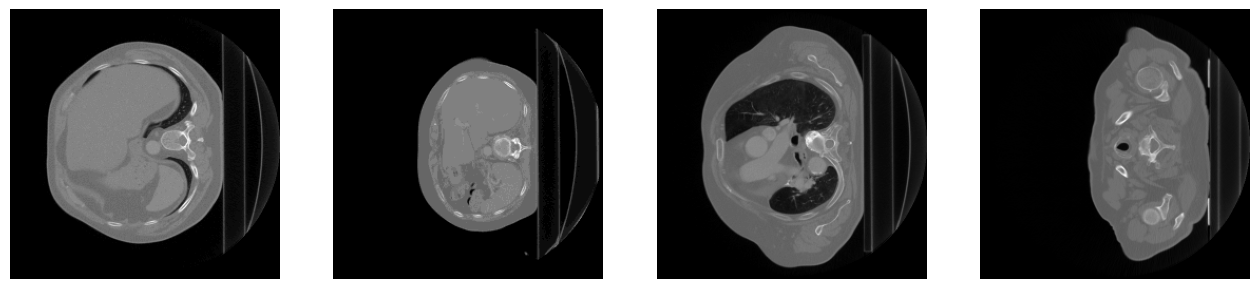

In [92]:
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, ContrastAugmentationTransform
import numpy as np

# Define the Contrast Transform
contrast_transform = ContrastAugmentationTransform(
    contrast_range=(0.65, 1.5),  # Multiply voxel intensities by x ∼ U(0.65, 1.5)
    p_per_sample=0.15  # Probability of applying contrast adjustment is 0.15
)

# Compose both transforms together
transform = Compose([  # Apply brightness adjustment
    contrast_transform  # Apply contrast adjustment
])

# Initialize the multi-threaded augmenter with brightness and contrast transformations
multithreaded_generator = MultiThreadedAugmenter(
    batchgen,  # Your batch generator that provides batches of images
    transform,  # Apply both brightness and contrast transformations
    num_processes=4,  # Number of parallel processes
    num_cached_per_queue=2,  # Number of batches to cache in memory
    seeds=None  # Use random seeds for augmentation
)

# Plot the next augmented batch
plot_batch(next(multithreaded_generator))

## Low resolution, gamma, mirroring

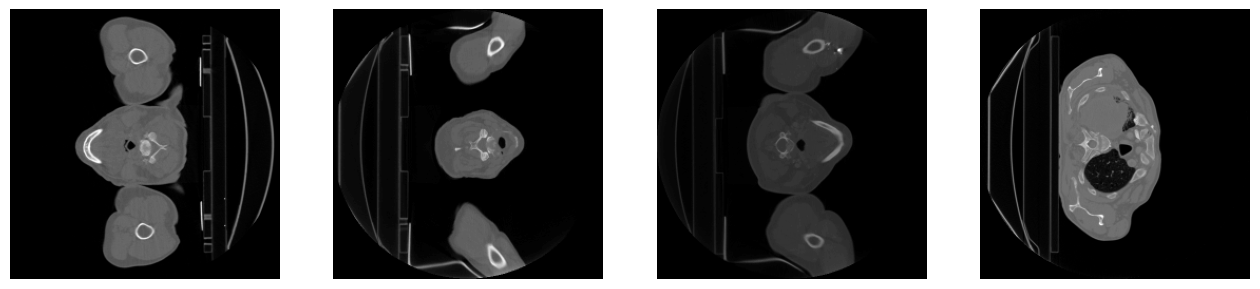

In [95]:
from batchgenerators.transforms.resample_transforms import SimulateLowResolutionTransform
from batchgenerators.transforms.color_transforms import GammaTransform
from batchgenerators.transforms.spatial_transforms import MirrorTransform


# Low Resolution Simulation
low_res_transform = SimulateLowResolutionTransform(
    zoom_range=(1, 2),  # Downsampling factor is sampled from U(1, 2)
    per_channel=True,  # Apply downsampling independently to each modality
    p_per_sample=0.25,  # Probability of applying this transform per sample
    p_per_channel=0.5,  # Probability of applying this transform per modality
    order_downsample=0,  # Nearest neighbor interpolation for downsampling
    order_upsample=3  # Cubic interpolation for upsampling
)

# Gamma Augmentation
gamma_transform = GammaTransform(
    gamma_range=(0.7, 1.5),  # Gamma correction factor sampled from U(0.7, 1.5)
    invert_image=True,  # Optionally invert image intensities
    per_channel=True,  # Apply gamma correction per modality
    retain_stats=True,  # Ensure voxel intensities are scaled back to their original range
    p_per_sample=0.15,  # Probability of applying gamma correction
)

# Mirroring
mirror_transform = MirrorTransform(
    axes=(0, 1, 2),  # Allow mirroring along all axes (for 3D data; use (0, 1) for 2D)
    p_per_sample=0.5  # Probability of applying mirroring
)

# Compose the transformations
transform = Compose([
    low_res_transform,  # Apply low-resolution simulation
    gamma_transform,  # Apply gamma correction
    mirror_transform  # Apply mirroring
])

# Initialize the multi-threaded augmenter with the composed transformations
multithreaded_generator = MultiThreadedAugmenter(
    batchgen,  # Your batch generator that provides batches of images
    transform,  # Apply the composed transformations
    num_processes=4,  # Number of parallel processes
    num_cached_per_queue=2,  # Number of batches to cache in memory
    seeds=None  # Use random seeds for augmentation
)

# Plot the next augmented batch
plot_batch(next(multithreaded_generator))

## ALLE TRANSFORMATIONS

In [96]:
transform_all = transform = Compose([
    rotation_transform,
    scale_transform,
    noise_transform,
    blur_transform,
    brightness_transform,
    contrast_transform,
    low_res_transform,  # Apply low-resolution simulation
    gamma_transform,  # Apply gamma correction
    mirror_transform  # Apply mirroring
])

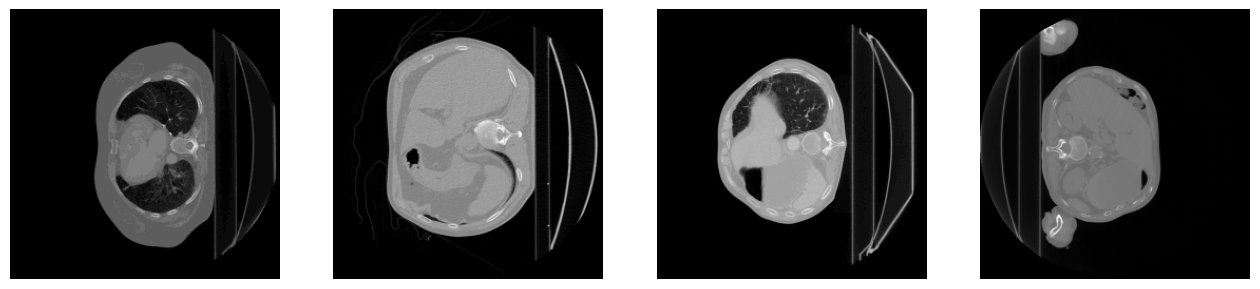

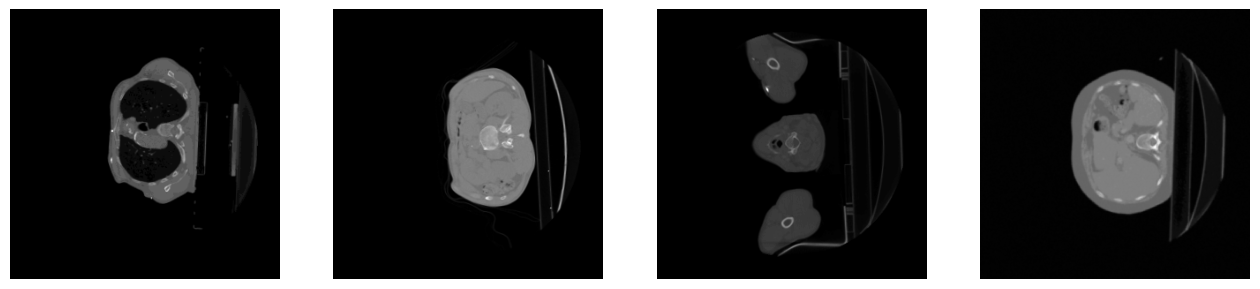

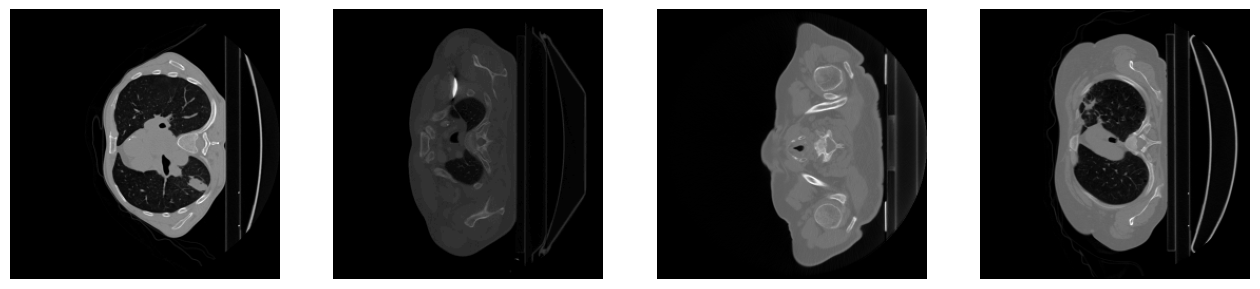

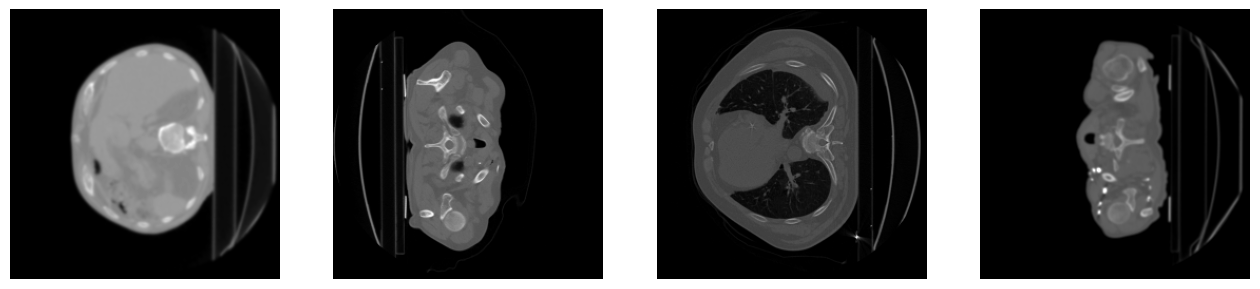

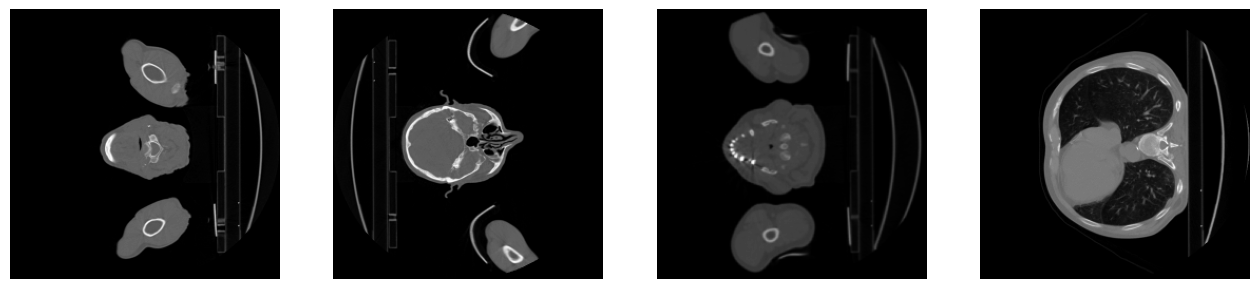

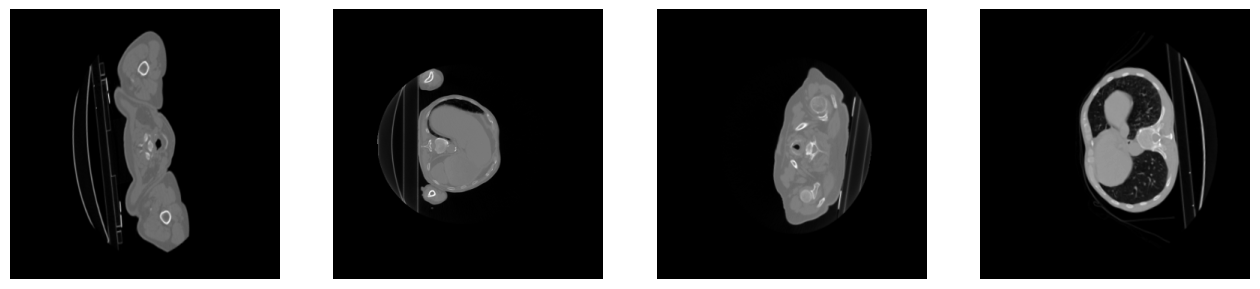

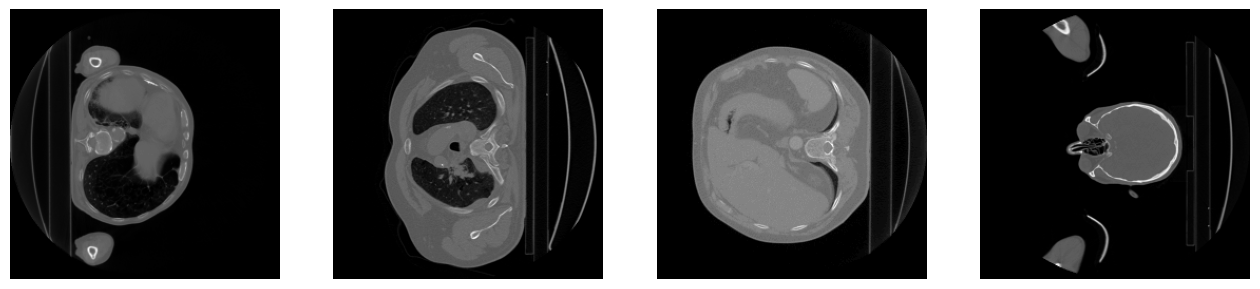

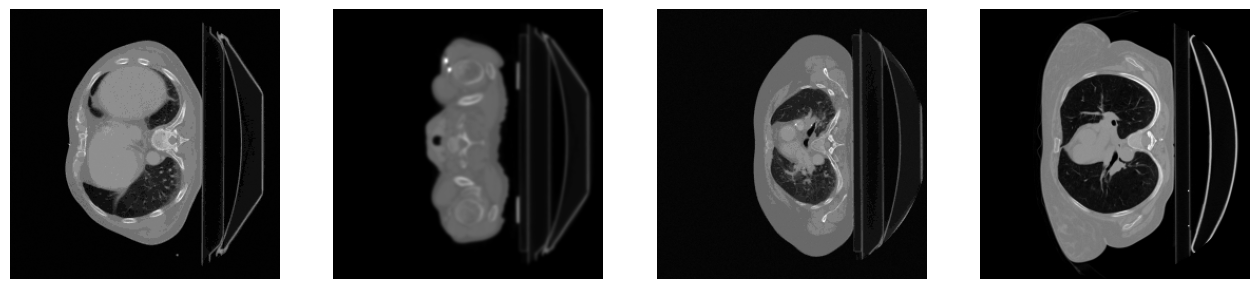

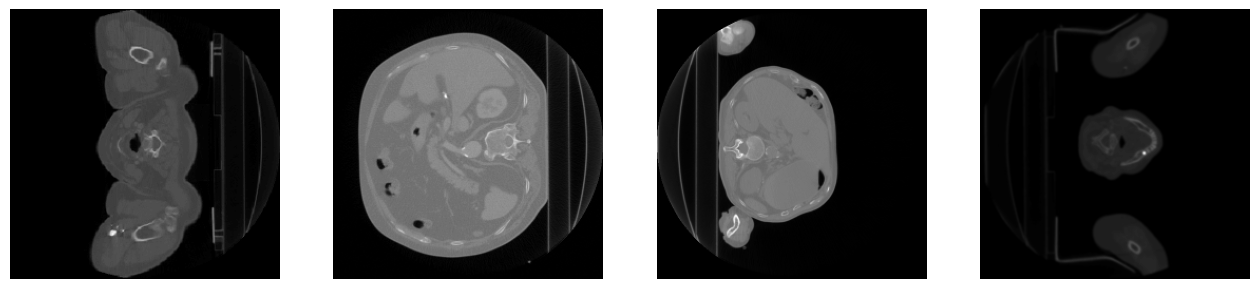

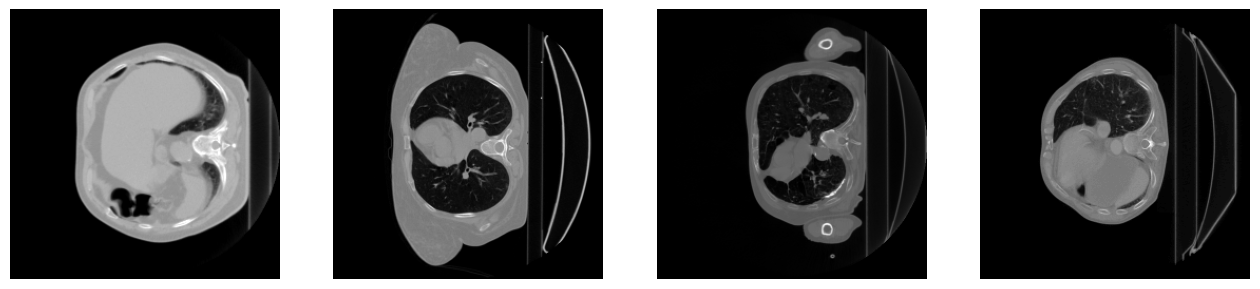

In [100]:
multithreaded_generator = MultiThreadedAugmenter(
    batchgen,  # Your batch generator that provides batches of images
    transform_all,  # Apply the composed transformations
    num_processes=4,  # Number of parallel processes
    num_cached_per_queue=2,  # Number of batches to cache in memory
    seeds=None  # Use random seeds for augmentation
)

# Plot the next augmented batch
for _ in range(10):
    plot_batch(next(multithreaded_generator))

In [132]:
import numpy as np
import os
import argparse
from skimage.io import imread, imsave
import matplotlib.pyplot as plt

from batchgenerators.dataloading.data_loader import SlimDataLoaderBase
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter
from batchgenerators.transforms.abstract_transforms import Compose
from batchgenerators.transforms.spatial_transforms import SpatialTransform, MirrorTransform
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform, GaussianBlurTransform
from batchgenerators.transforms.color_transforms import ContrastAugmentationTransform, BrightnessMultiplicativeTransform, GammaTransform
from batchgenerators.transforms.resample_transforms import SimulateLowResolutionTransform
from batchgenerators.transforms.abstract_transforms import RndTransform
from multithreaded_dataloading import CTImageDataset

# ------------------- Data Loading Component for CT Data -------------------

# class CTImageDataset(SlimDataLoaderBase):
#     """
#     Custom DataLoader to handle paired CT images and ground truth masks for medical image processing.
#     """

#     def __init__(self, images, gts, batch_size):
#         super(CTImageDataset, self).__init__(None, batch_size)
#         self.images = [self.add_channel_dim(img) for img in images]  # Add channel dimension
#         self.gts = [self.add_channel_dim(gt) for gt in gts]  # Add channel dimension to GT
#         self.images = [img.astype(np.float32) for img in self.images]  # Ensure float32 for consistency
#         self.gts = [gt.astype(np.float32) for gt in self.gts]  # Ensure float32 for GT as well

#     def add_channel_dim(self, img):
#         return np.expand_dims(img, axis=0)  # Add channel dimension (1, H, W)

#     def generate_train_batch(self):
#         # Randomly select indices for the batch
#         indices = np.random.choice(len(self.images), self.batch_size, replace=False)
#         batch_data = np.stack([self.images[i] for i in indices], axis=0)
#         batch_gts = np.stack([self.gts[i] for i in indices], axis=0)
#         return {'data': batch_data, 'gt': batch_gts}  # Return both input data and GT


def load_ct_images_and_gts(image_folder, gt_folder):
    """
    Load paired CT images and corresponding GT masks from the specified folders.
    """
    images = []
    gts = []
    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        gt_path = os.path.join(gt_folder, filename)
        
        if os.path.exists(gt_path):
            img = imread(img_path)
            gt = imread(gt_path)
            if img is not None and gt is not None:
                images.append(img)
                gts.append(gt)
    return images, gts


def plot_batch(batch):
    """
    Visualize a batch of images and their ground truth.
    """
    batch_size = batch['data'].shape[0]
    plt.figure(figsize=(16, 10))
    for i in range(batch_size):
        plt.subplot(2, batch_size, i + 1)
        plt.imshow(batch['data'][i, 0], cmap="gray")  # Visualize input image
        plt.axis('off')
        plt.subplot(2, batch_size, batch_size + i + 1)
        plt.imshow(batch['gt'][i, 0], cmap="gray")  # Visualize GT
        plt.axis('off')
    plt.show()


def save_augmented_images(batch, output_folder, prefix="augmented"):
    """
    Save the augmented images and GT masks to the specified output folder.
    
    Args:
        batch (dict): The augmented batch of images and GTs.
        output_folder (str): The directory where the images will be saved.
        prefix (str): The prefix to add to each saved image filename.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, (img, gt) in enumerate(zip(batch['data'], batch['gt'])):
        img = np.squeeze(img)  # Remove single-dimensional entries from the shape (H, W)
        gt = np.squeeze(gt)  # Remove single-dimensional entries from the shape (H, W)

        img_save_path = os.path.join(output_folder, f"{prefix}_image_{i}.png")
        gt_save_path = os.path.join(output_folder, f"{prefix}_gt_{i}.png")

        imsave(img_save_path, img)
        imsave(gt_save_path, gt)

        print(f"Saved {img_save_path} and {gt_save_path}")


# ------------------- Augmentation Component -------------------

class AugmentationPipeline:
    """
    Defines the augmentation pipeline, which includes spatial transformations, noise, and contrast/brightness augmentations.
    """

    def __init__(self, target_patch_size, oversized_factor=1.2):
        self.target_patch_size = target_patch_size
        self.oversized_patch_size = (int(target_patch_size[0] * oversized_factor), int(target_patch_size[1] * oversized_factor))

        
    def get_rotation_transform(self):
        return RndTransform(SpatialTransform(
            patch_size=self.oversized_patch_size,
            patch_center_dist_from_border=np.array(self.oversized_patch_size) // 2,
            do_rotation=True,
            angle_x=(-0.174532925, 0.174532925),  # Rotate between -10 to +10 degrees on the z-axis

            # Disable all other transformations
            do_elastic_deform=False,  # Disable elastic deformation
            do_scale=False,  # Disable scaling
            random_crop=False,  # Disable random cropping (center crop is used by default)
            independent_scale_for_each_axis=False,  # Disable independent scaling

            # Border handling (to avoid artifacts when rotating)
            border_mode_data='constant',  # Handle borders by padding with constant values
            border_cval_data=0,  # Pad the image with 0 (black) outside its original boundaries
            order_data=1  # Linear interpolation for smooth rotation
        ), prob=0.2)
    
    def get_scale_transform(self):
        return RndTransform(SpatialTransform(
            patch_size=self.oversized_patch_size,  # Output image patch size after padding
            patch_center_dist_from_border=np.array(self.oversized_patch_size) // 2,  # Center the patch

            # Enable rotation
            do_rotation=False,
            # Disable all other transformations
            do_elastic_deform=False,  # Disable elastic deformation
            do_scale=True,  # Disable scaling
            scale=(0.7, 1.4),  # Scale between 0.5 and
            random_crop=False,  # Disable random cropping (center crop is used by default)
            independent_scale_for_each_axis=True,  # Disable independent scaling

            # Border handling (to avoid artifacts when rotating)
            border_mode_data='constant',  # Handle borders by padding with constant values
            border_cval_data=0,  # Pad the image with 0 (black) outside its original boundaries
            order_data=1  # Linear interpolation for smooth rotation
        ), prob=0.2)


    def get_noise_transform(self):
        return GaussianNoiseTransform(
            noise_variance=(0, 0.1),
            p_per_sample=0.15  # Probability of applying noise
        )

    def get_blur_transform(self):
        return GaussianBlurTransform(
            blur_sigma=(0.5, 1.5),
            different_sigma_per_channel=True,
            p_per_sample=0.2,
            p_per_channel=0.5
        )

    def get_brightness_transform(self):
        return BrightnessMultiplicativeTransform(
            multiplier_range=(0.7, 1.3),
            p_per_sample=0.15
        )

    def get_contrast_transform(self):
        return ContrastAugmentationTransform(
            contrast_range=(0.65, 1.5),
            p_per_sample=0.15
        )

    # XXX
    def get_low_res_transform(self):
        return SimulateLowResolutionTransform(
            zoom_range=(1, 2),
            per_channel=True,
            p_per_sample=0.25,
            p_per_channel=0.5,
            order_downsample=0,
            order_upsample=3
        )

    def get_gamma_transform(self):
        return GammaTransform(
            gamma_range=(0.7, 1.5),
            invert_image=True,
            per_channel=True,
            retain_stats=True,
            p_per_sample=0.15,
        )

    def get_mirror_transform(self):
        return MirrorTransform(
            axes=(0, 1, 2),
            p_per_sample=0.5
        )

    def create_pipeline(self):
        """
        Create the full augmentation pipeline.
        """
        return Compose([
            self.get_rotation_transform(),
            self.get_scale_transform(),
            self.get_noise_transform(),
            self.get_blur_transform(),
            self.get_brightness_transform(),
            self.get_contrast_transform(),
            self.get_low_res_transform(),
            self.get_gamma_transform(),
            self.get_mirror_transform()
        ])

    def create_data_generator(self, batchgen, num_processes=4, num_cached_per_queue=2):
        """
        Initialize a multi-threaded data generator with the augmentation pipeline.
        """
        augmentation_pipeline = self.create_pipeline()

        # Create the multi-threaded augmenter
        return MultiThreadedAugmenter(
            batchgen,
            augmentation_pipeline,
            num_processes=num_processes,
            num_cached_per_queue=num_cached_per_queue,
            seeds=None
        )


In [133]:


# Load the paired CT images and GTs from the specified folders
train_images, train_gts = load_ct_images_and_gts('/Users/sachabuijs/Documents/AI4MI/data/SEGTHOR_MANUAL_SPLIT/train/img', '/Users/sachabuijs/Documents/AI4MI/data/SEGTHOR_MANUAL_SPLIT/train/gt')

# Initialize the data loader with the parsed batch size
batchgen = CTImageDataset(train_images, train_gts, batch_size=4)


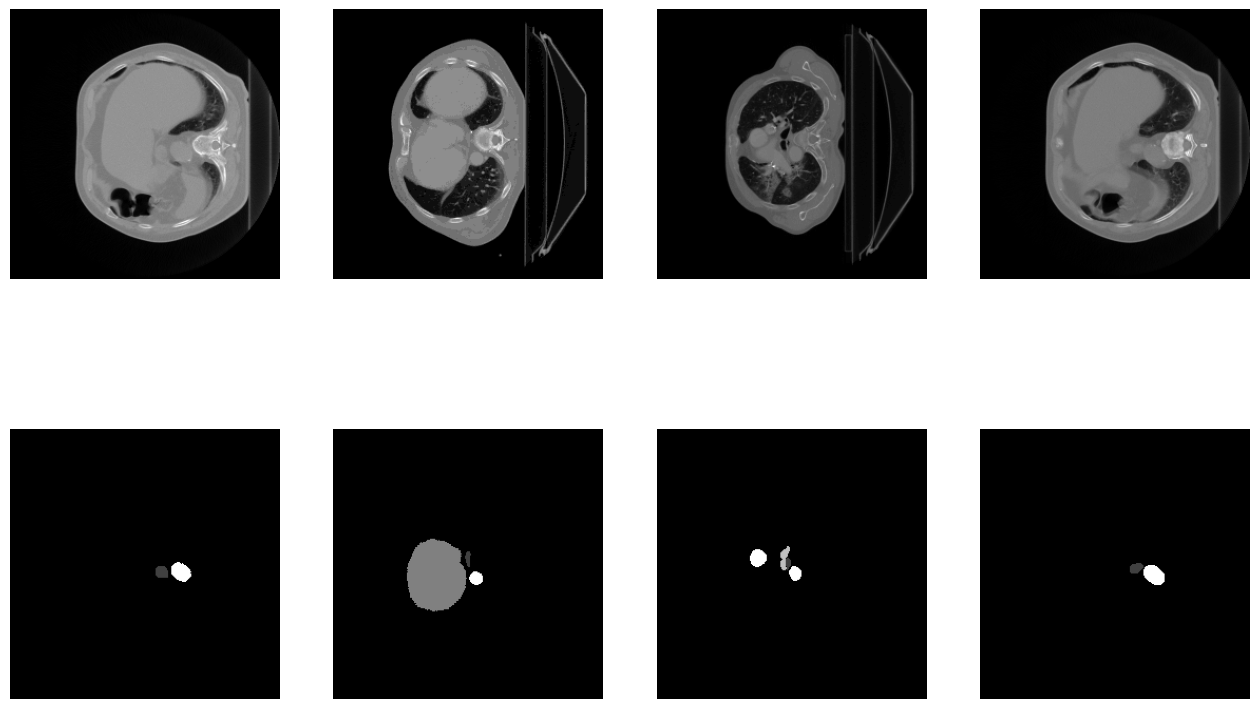

In [134]:

plot_batch(next(batchgen))

In [139]:

# Initialize the augmentation pipeline with the target patch size
target_patch_size = train_images[0].shape[:2]  # Assuming HxW image
print(target_patch_size)
augmentation_pipeline = AugmentationPipeline(target_patch_size)

# Create the data generator with augmentations, based on parsed arguments
augmented_data_generator = augmentation_pipeline.create_data_generator(batchgen, num_processes=4, num_cached_per_queue=2)


(256, 256)


In [136]:

# Retrieve a batch of augmented images and ground truths
augmented_batch = next(augmented_data_generator)


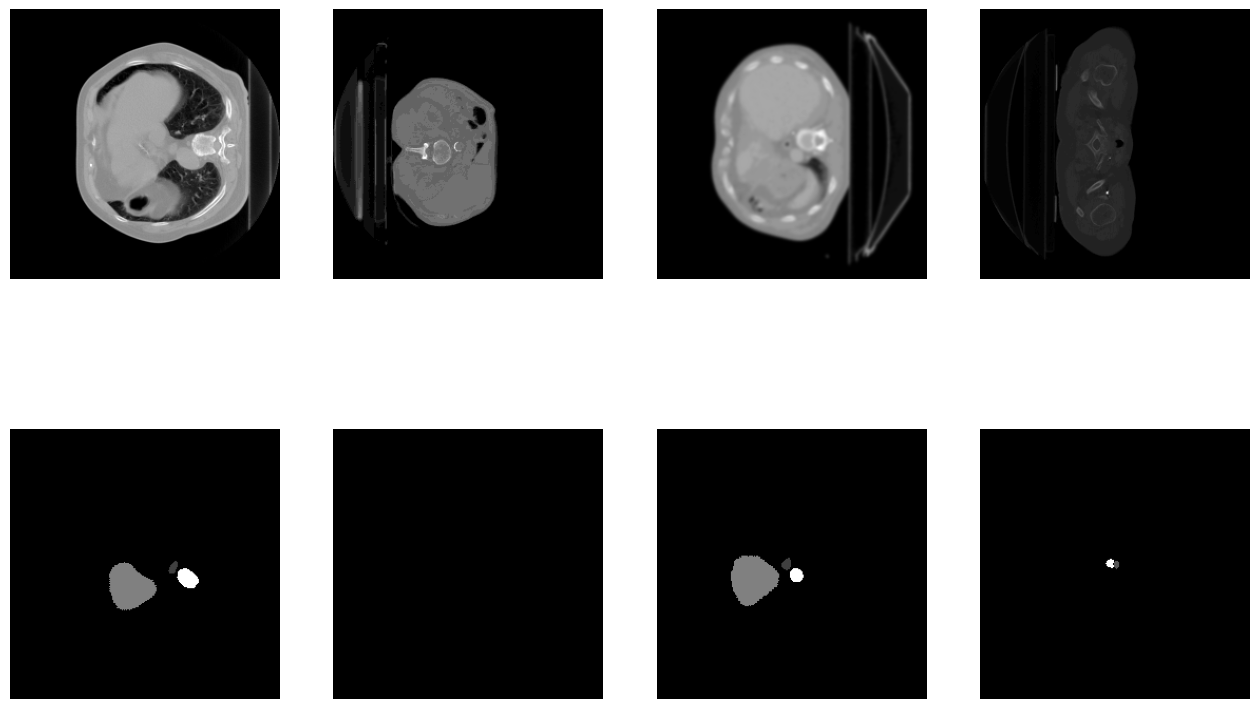

In [137]:

# Plot the augmented batch (input images and GTs)
plot_batch(augmented_batch)
